<a href="https://colab.research.google.com/github/ahmedsafi2/image-segmentation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch
!pip install torchvision

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pytorch)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import cv2


In [3]:
class KMeansSegmentation:
    def __init__(self, n_clusters=5, feature_mode='color', use_position=False):
        """
        Initialize K-means segmentation

        Args:
            n_clusters: Number of segments/clusters
            feature_mode: 'color' for RGB features, 'gradient' for gradient features, 'both' for both
            use_position: Whether to include pixel positions (x,y) as features
        """
        self.n_clusters = n_clusters
        self.feature_mode = feature_mode
        self.use_position = use_position
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

    def _extract_features(self, image):
        """
        Extract features from image based on feature_mode

        Args:
            image: numpy array of shape (H, W, C)

        Returns:
            features: numpy array of shape (H*W, D) where D is the feature dimension
        """
        h, w, c = image.shape
        features = []

        # Color features (RGB values)
        if self.feature_mode in ['color', 'both']:
            color_features = image.reshape(-1, c)
            features.append(color_features)

        # Gradient features
        if self.feature_mode in ['gradient', 'both']:
            # Calculate gradients
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
            sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
            gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
            gradient_direction = np.arctan2(sobel_y, sobel_x)

            # Normalize gradients
            gradient_magnitude = gradient_magnitude / np.max(gradient_magnitude)
            gradient_direction = (gradient_direction + np.pi) / (2 * np.pi)

            gradient_features = np.column_stack((
                gradient_magnitude.reshape(-1),
                gradient_direction.reshape(-1)
            ))
            features.append(gradient_features)

        # Position features (x, y coordinates)
        if self.use_position:
            y_coords, x_coords = np.mgrid[0:h, 0:w]
            # Normalize coordinates to [0, 1]
            x_coords = x_coords / float(w)
            y_coords = y_coords / float(h)
            position_features = np.column_stack((
                x_coords.reshape(-1),
                y_coords.reshape(-1)
            ))
            features.append(position_features)

        # Concatenate all features
        all_features = np.hstack(features)

        # Normalize features
        for i in range(all_features.shape[1]):
            min_val = np.min(all_features[:, i])
            max_val = np.max(all_features[:, i])
            if max_val > min_val:
                all_features[:, i] = (all_features[:, i] - min_val) / (max_val - min_val)

        return all_features

    def segment(self, image):
        """
        Segment image using K-means clustering

        Args:
            image: numpy array of shape (H, W, C)

        Returns:
            segmented_image: numpy array of shape (H, W, C) with segment colors
            labels: numpy array of shape (H, W) with segment labels
        """
        h, w, c = image.shape

        # Extract features
        features = self._extract_features(image)

        # Perform K-means clustering
        self.kmeans.fit(features)
        labels = self.kmeans.labels_

        # Reshape labels to image dimensions
        labels_image = labels.reshape(h, w)

        # Create segmented image by replacing each pixel with its cluster center
        segmented_image = np.zeros_like(image)
        for i in range(self.n_clusters):
            mask = labels_image == i
            # Average color of pixels in this cluster
            if np.any(mask):
                average_color = np.mean(image[mask], axis=0)
                segmented_image[mask] = average_color

        return segmented_image, labels_image

    def segment_with_boundaries(self, image):
        """
        Segment image and highlight boundaries between segments

        Args:
            image: numpy array of shape (H, W, C)

        Returns:
            result: numpy array of shape (H, W, C) with segment colors and boundaries
        """
        segmented, labels = self.segment(image)

        # Find boundaries
        boundaries = np.zeros_like(labels, dtype=np.uint8)

        # Check for label changes horizontally and vertically
        h, w = labels.shape
        for i in range(1, h):
            boundaries[i, :] = (labels[i, :] != labels[i-1, :]).astype(np.uint8)

        for j in range(1, w):
            boundaries[:, j] |= (labels[:, j] != labels[:, j-1]).astype(np.uint8)

        # Dilate boundaries to make them more visible
        kernel = np.ones((3, 3), np.uint8)
        boundaries = cv2.dilate(boundaries, kernel, iterations=1)

        # Create result with boundaries
        result = segmented.copy()
        result[boundaries == 1] = [0, 0, 0]  # Mark boundaries as black

        return result, labels


In [4]:

class SuperpixelSegmentation:
    def __init__(self, n_segments=100, compactness=10, sigma=1, algorithm='slic'):
        """
        Initialize superpixel segmentation

        Args:
            n_segments: Number of superpixels
            compactness: Compactness parameter for SLIC
            sigma: Width of Gaussian smoothing kernel
            algorithm: 'slic' or 'seeds' or 'quickshift'
        """
        self.n_segments = n_segments
        self.compactness = compactness
        self.sigma = sigma
        self.algorithm = algorithm

    def segment(self, image):
        """
        Segment image using superpixels

        Args:
            image: numpy array of shape (H, W, C)

        Returns:
            segmented_image: numpy array of shape (H, W, C) with superpixel colors
            labels: numpy array of shape (H, W) with superpixel labels
        """
        from skimage.segmentation import slic, mark_boundaries

        # Convert image to lab color space
        lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        # Generate superpixels
        if self.algorithm == 'slic':
            labels = slic(lab_image, n_segments=self.n_segments,
                          compactness=self.compactness, sigma=self.sigma)
        else:
            # For other algorithms, we'd implement them here
            raise NotImplementedError(f"Algorithm {self.algorithm} not implemented")

        # Create segmented image by replacing each pixel with its superpixel average color
        segmented_image = np.zeros_like(image)
        for i in np.unique(labels):
            mask = labels == i
            if np.any(mask):
                average_color = np.mean(image[mask], axis=0)
                segmented_image[mask] = average_color

        # Mark boundaries on the original image
        boundaries_image = mark_boundaries(image, labels)

        return segmented_image, labels, boundaries_image

class RegionGrowingSegmentation:
    def __init__(self, threshold=10, seed_method='grid', n_seeds=5):
        """
        Initialize region growing segmentation

        Args:
            threshold: Intensity threshold for region growing
            seed_method: 'grid' or 'random' for seed point selection
            n_seeds: Number of seed points along each dimension
        """
        self.threshold = threshold
        self.seed_method = seed_method
        self.n_seeds = n_seeds

    def _get_seed_points(self, image):
        """
        Get seed points for region growing

        Args:
            image: numpy array of shape (H, W, C)

        Returns:
            seeds: list of (y, x) coordinates
        """
        h, w, _ = image.shape
        seeds = []

        if self.seed_method == 'grid':
            # Place seeds on a grid
            y_step = h // (self.n_seeds + 1)
            x_step = w // (self.n_seeds + 1)

            for i in range(1, self.n_seeds + 1):
                for j in range(1, self.n_seeds + 1):
                    y = i * y_step
                    x = j * x_step
                    seeds.append((y, x))

        elif self.seed_method == 'random':
            # Place seeds randomly
            total_seeds = self.n_seeds ** 2
            for _ in range(total_seeds):
                y = np.random.randint(0, h)
                x = np.random.randint(0, w)
                seeds.append((y, x))

        return seeds

    def _grow_region(self, image, seed, threshold):
        """
        Grow region from seed point

        Args:
            image: numpy array of shape (H, W, C)
            seed: (y, x) coordinates of seed point
            threshold: Intensity threshold

        Returns:
            region: binary mask of region
        """
        h, w, c = image.shape
        seed_y, seed_x = seed
        seed_color = image[seed_y, seed_x]

        # Initialize region and stack
        region = np.zeros((h, w), dtype=bool)
        region[seed_y, seed_x] = True
        stack = [seed]

        # 4-connectivity neighborhood
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]

        while stack:
            y, x = stack.pop()
            for dy, dx in directions:
                ny, nx = y + dy, x + dx

                if (0 <= ny < h and 0 <= nx < w and
                    not region[ny, nx] and
                    np.sum((image[ny, nx] - seed_color)**2) <= threshold**2):
                    region[ny, nx] = True
                    stack.append((ny, nx))

        return region

    def segment(self, image):
        """
        Segment image using region growing

        Args:
            image: numpy array of shape (H, W, C)

        Returns:
            segmented_image: numpy array of shape (H, W, C) with region colors
            labels: numpy array of shape (H, W) with region labels
        """
        h, w, c = image.shape

        # Get seed points
        seeds = self._get_seed_points(image)

        # Initialize labels
        labels = np.zeros((h, w), dtype=int)

        # Grow regions from seeds
        for i, seed in enumerate(seeds):
            region = self._grow_region(image, seed, self.threshold)
            # Assign label only to pixels that are not already labeled
            labels[region & (labels == 0)] = i + 1

        # Assign remaining pixels to nearest region
        if np.any(labels == 0):
            remaining = np.where(labels == 0)
            remaining_coords = list(zip(remaining[0], remaining[1]))

            for y, x in remaining_coords:
                min_dist = float('inf')
                nearest_label = 0

                for i, seed in enumerate(seeds):
                    seed_y, seed_x = seed
                    dist = (y - seed_y)**2 + (x - seed_x)**2
                    if dist < min_dist:
                        min_dist = dist
                        nearest_label = i + 1

                labels[y, x] = nearest_label

        # Create segmented image
        segmented_image = np.zeros_like(image)
        for i in range(1, len(seeds) + 1):
            mask = labels == i
            if np.any(mask):
                average_color = np.mean(image[mask], axis=0)
                segmented_image[mask] = average_color

        return segmented_image, labels

# Function to load and preprocess images for segmentation
def load_image(image_path, size=None):
    """
    Load and preprocess image for segmentation

    Args:
        image_path: Path to image file
        size: (width, height) to resize image to, or None for no resizing

    Returns:
        image: numpy array of shape (H, W, C)
    """
    # Load image
    img = Image.open(image_path)

    # Resize if specified
    if size is not None:
        img = img.resize(size)

    # Convert to numpy array
    image = np.array(img)

    return image

# Function to visualize segmentation results
def visualize_segmentation(original, segmented, labels=None, save_path=None):
    """
    Visualize segmentation results

    Args:
        original: Original image as numpy array
        segmented: Segmented image as numpy array
        labels: Segmentation labels as numpy array (optional)
        save_path: Path to save visualization to (optional)
    """
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(131)
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')

    # Segmented image
    plt.subplot(132)
    plt.imshow(segmented)
    plt.title('Segmented Image')
    plt.axis('off')

    # Segmentation labels if provided
    if labels is not None:
        plt.subplot(133)
        plt.imshow(labels, cmap='nipy_spectral')
        plt.title('Segmentation Labels')
        plt.axis('off')

    plt.tight_layout()

    # Save if requested
    if save_path:
        plt.savefig(save_path)

    plt.show()

# Torch Dataset for batch processing
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Dataset for batch processing of images

        Args:
            image_dir: Directory containing images
            transform: torchvision transforms to apply
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir)
                          if os.path.isfile(os.path.join(image_dir, f)) and
                          f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.image_files[idx]


Running K-means segmentation...


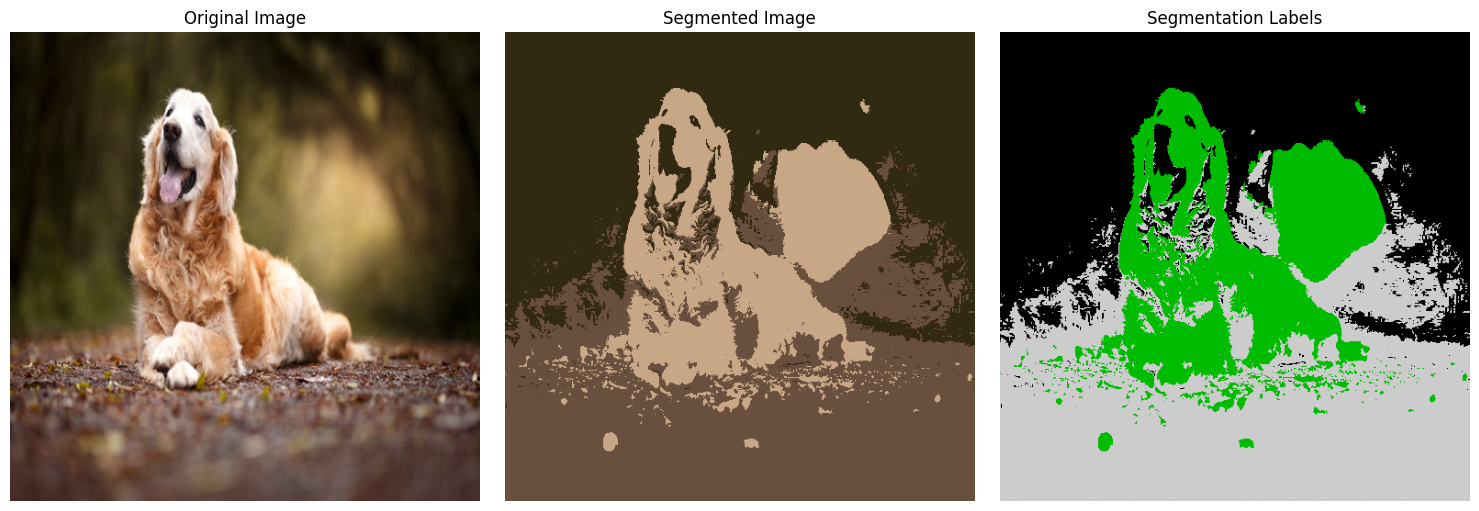

Running K-means segmentation with boundaries...


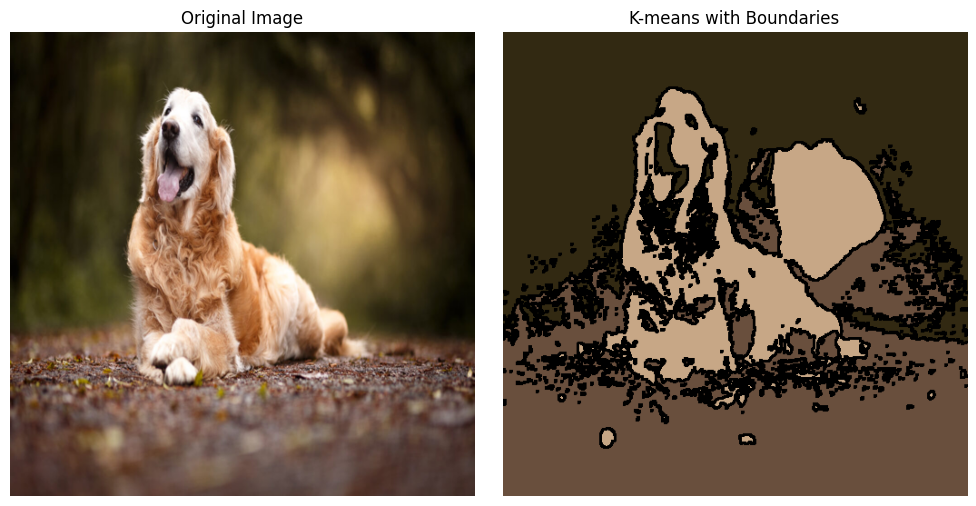

Running superpixel segmentation...


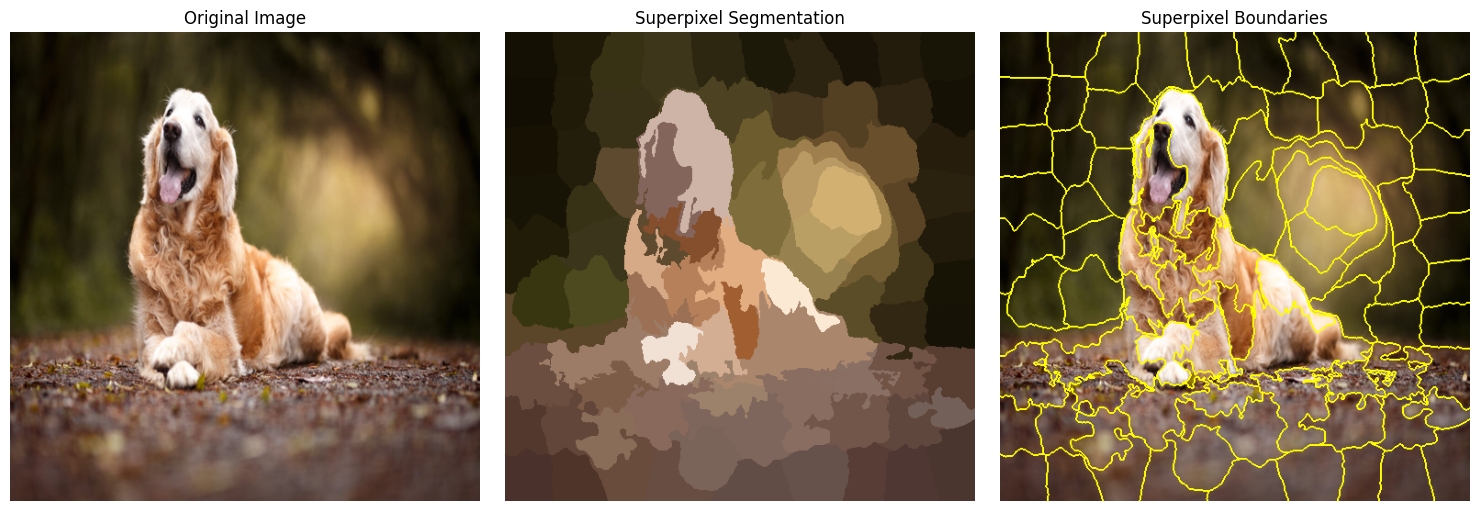

Running region growing segmentation...


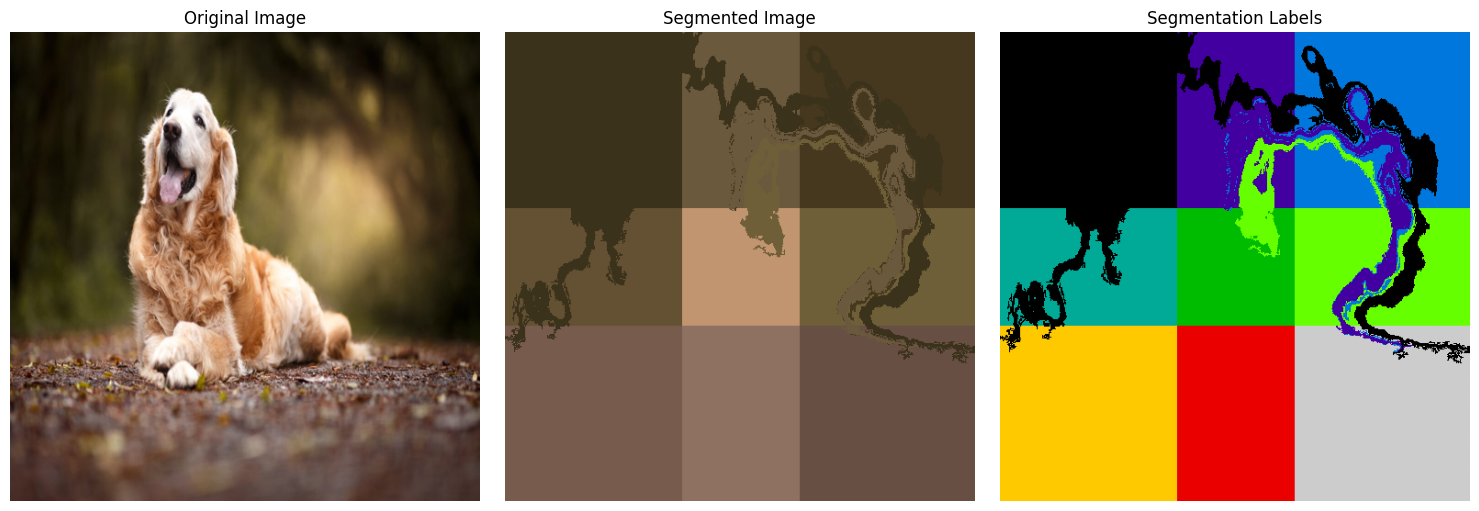

Done!


In [6]:
def main():
    # Path to example image
    image_path = "dog.jpg"  # Change to your image path

    # Load image
    image = load_image(image_path, size=(512, 512))

    print("Running K-means segmentation...")

    # K-means segmentation
    kmeans_seg = KMeansSegmentation(n_clusters=3, feature_mode='both', use_position=True)
    kmeans_result, kmeans_labels = kmeans_seg.segment(image)

    # Visualize K-means results
    visualize_segmentation(image, kmeans_result, kmeans_labels, save_path="kmeans_segmentation.png")

    print("Running K-means segmentation with boundaries...")

    # K-means with boundaries
    kmeans_boundaries, _ = kmeans_seg.segment_with_boundaries(image)

    # Visualize K-means with boundaries
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(kmeans_boundaries)
    plt.title('K-means with Boundaries')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig("kmeans_boundaries.png")
    plt.show()

    print("Running superpixel segmentation...")

    # Superpixel segmentation
    try:
        superpixel_seg = SuperpixelSegmentation(n_segments=100, compactness=10)
        superpixel_result, superpixel_labels, superpixel_boundaries = superpixel_seg.segment(image)

        # Visualize superpixel results
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(132)
        plt.imshow(superpixel_result)
        plt.title('Superpixel Segmentation')
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(superpixel_boundaries)
        plt.title('Superpixel Boundaries')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig("superpixel_segmentation.png")
        plt.show()
    except Exception as e:
        print(f"Superpixel segmentation failed: {e}")

    print("Running region growing segmentation...")

    # Region growing segmentation
    region_seg = RegionGrowingSegmentation(threshold=15, seed_method='grid', n_seeds=3)
    region_result, region_labels = region_seg.segment(image)

    # Visualize region growing results
    visualize_segmentation(image, region_result, region_labels, save_path="region_growing.png")

    print("Done!")

if __name__ == "__main__":
    main()